# Analyse ROMY Event - Demo 1

ROMY data of an M6.8 event in 2023 is analyzed loading data from a local MSEED file.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_spectra_comparison_fill import plot_spectra_comparison_fill


## Configurations

Here we load the data from a local mseed file (data_source = "mseed_file"). All parameters for the processing and plotting are set hereafter in the configuration dictionary.

In the MSEED file the station was renamed to XX.ROMY..*

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["XX.ROMY..BJZ", "XX.ROMY..BJN", "XX.ROMY..BJE"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["XX.ROMY..BHZ", "XX.ROMY..BHN", "XX.ROMY..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'twin_sec': 30,          # Window length in seconds
    'twin_overlap': 0.5,  # Window overlap in seconds
    'cc_threshold': 0.75,        # Cross-correlation threshold

    # Filter parameters
    'fmin': 0.02,               # Minimum frequency for filtering
    'fmax': 0.2,                # Maximum frequency for filtering
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Get key information about the event

In [4]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

Store the configuration as a yaml file

In [5]:
# define filename
filename = "./config/config_ROMY_M6.8_20230908.yml"

# store the configuration as a yaml file
sd.store_as_yaml(config, filename)


 -> file ./config/config_ROMY_M6.8_20230908.yml already exists. Aborting...


In [6]:
sd.load_data(config['tbeg'], config['tend'], resample_rate=5)

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples
-> resampling stream to 5 Hz
6 Trace(s) in Stream:
XX.ROMY..LHZ | 2023-09-08T22:12:58.989999

Ensure that all traces of stream have the same sample size

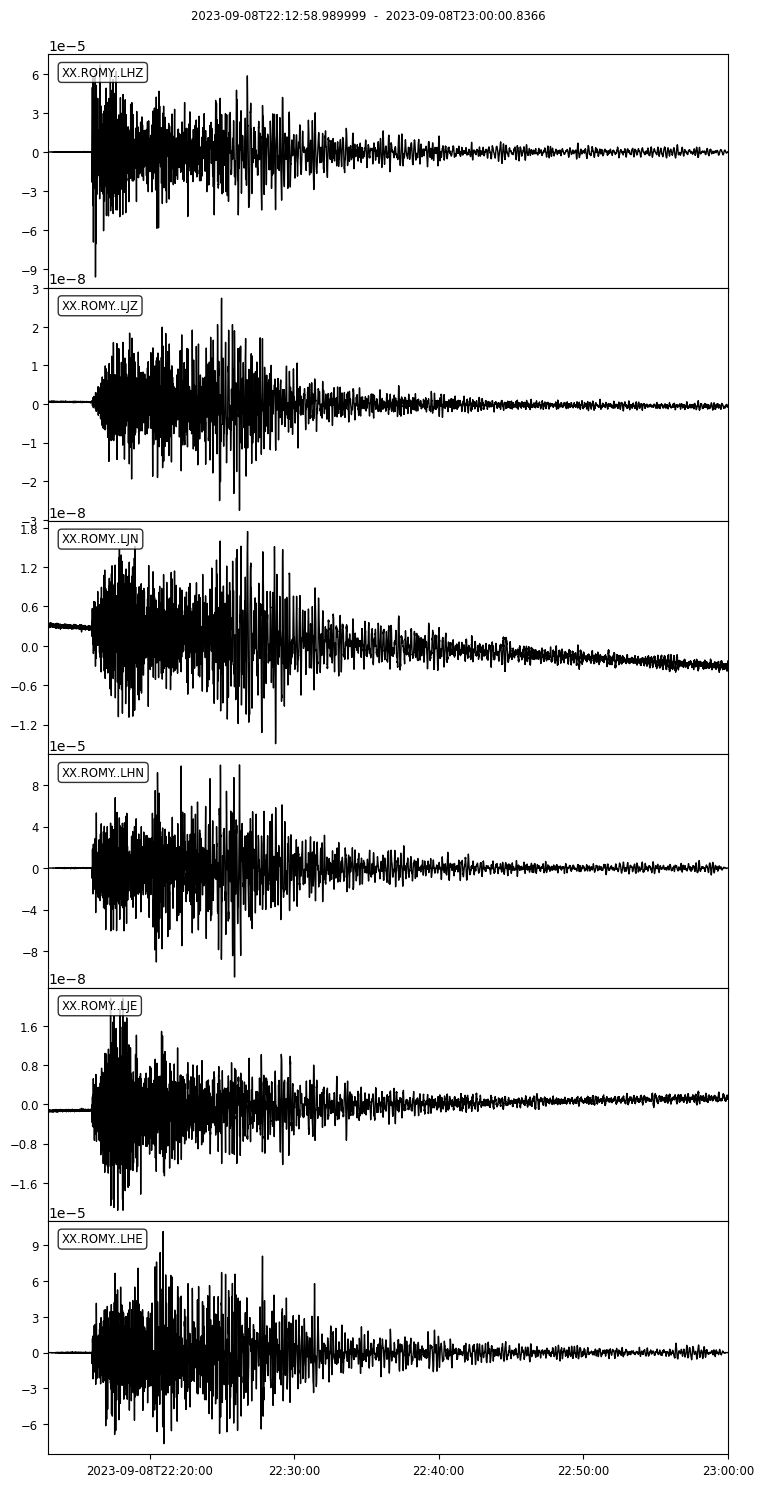

In [7]:
sd.st.plot(equal_scale=False);

Ensure alls traces have the same amount of samples

In [8]:
sd.trim_stream(set_common=True, set_interpolate=False)

## Analysis

### Wavelet Comparsion

In [9]:
# # First compute CWT for all components
# cwt_results = {}
# for comp in ['Z', 'N', 'E']:

#     try:
#         # Rotation components
#         rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
#         cwt_results[f"{rot_data.stats.channel}"] = sd.compute_cwt(
#             rot_data.times(),
#             rot_data.data,
#             rot_data.stats.delta,
#             normalize=True,
#             fmax=1,
#             fmin=0.01
#         )
#     except:
#         print(f"No {comp} data for rotation")
#     try:
#         # Translation components
#         acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
#         cwt_results[f"{acc_data.stats.channel}"] = sd.compute_cwt(
#             acc_data.times(),
#             acc_data.data,
#             acc_data.stats.delta,
#             normalize=True,
#             fmax=1,
#             fmin=0.01
#         )
#     except:
#         print(f"No {comp} data for ranslation")


In [10]:
# acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
# cwt_results[f"{acc_data.stats.channel}"] = sd.compute_cwt(
#     acc_data.times(),
#     acc_data.data,
#     acc_data.stats.delta,
#     normalize=True,
#     fmax=1,
#     fmin=0.01
# )

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [11]:
sd.filter_data(fmin=config['fmin'], fmax=config['fmax'], output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [12]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


Let's cut it to the main event

In [13]:
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)

Now, let's compare the waveforms of the rotation (red) and translational (black) components 

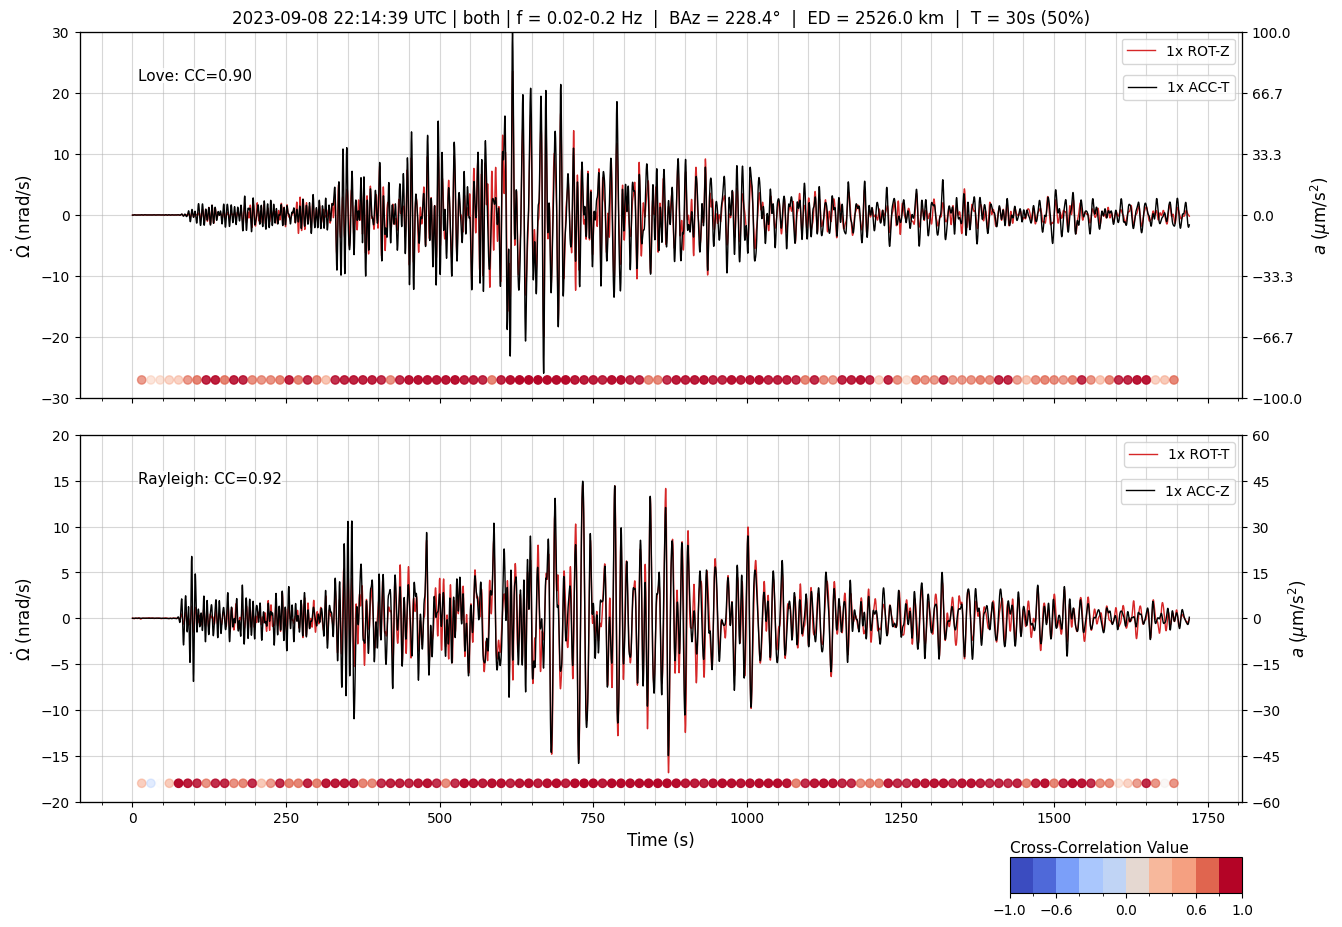

In [14]:
fig = plot_waveform_cc(
    sd_object=sd,
    twin_sec=config['twin_sec'],
    twin_overlap=config['twin_overlap'],
    wave_type="both"
)

Make spectra for the raw data

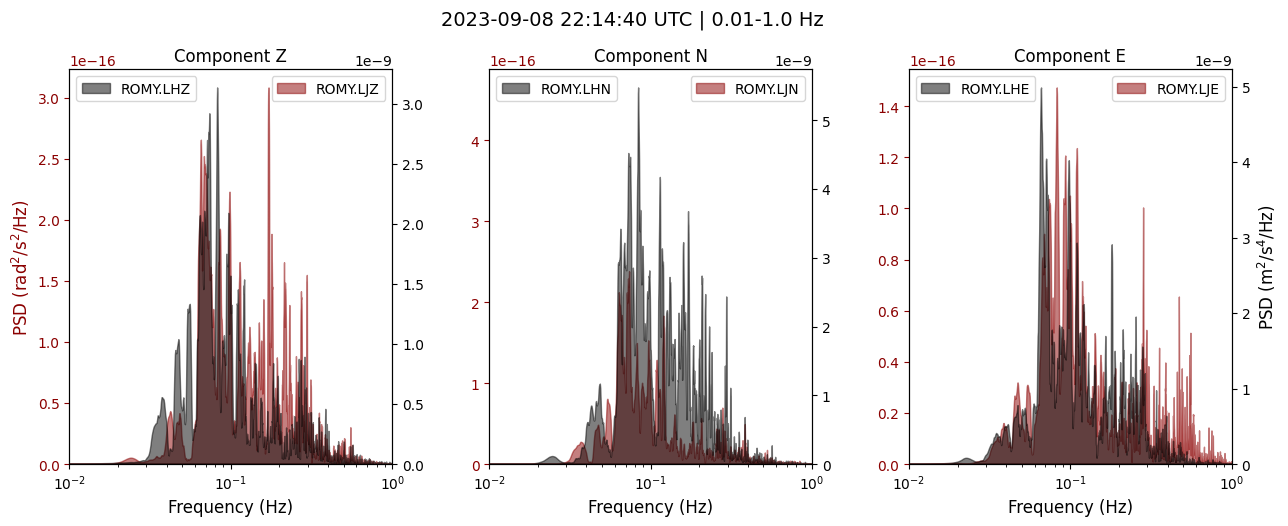

In [15]:
# Plot the spectra comparison
fig = plot_spectra_comparison_fill(
    rot=sd.get_stream("rotation", raw=True).copy(),
    acc=sd.get_stream("translation", raw=True).copy(),
    fmin=0.01,
    fmax=1.0,
    ylog=False,
    xlog=True,
    fill=True
)

Make spectra for the filtered data

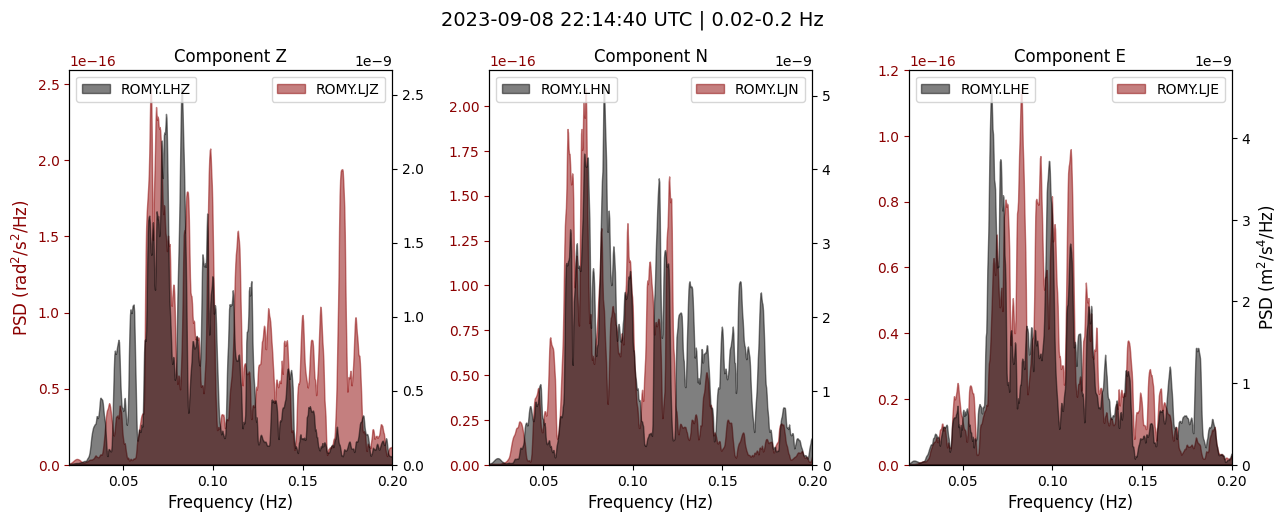

In [16]:
fig = plot_spectra_comparison_fill(
    sd_object=sd,
    ylog=False,
    xlog=False,
    fill=True
)

In [17]:
sd.st.select(channel="*JZ")[0].data *= 0

### Backazimuth Estimate

Computation of backazimuth results for Love waves using the midpoint CC-method

  Backazimuth array is empty.


/home/andbro/Downloads/SixDegreesOfFreedom/sixdegrees/plots/plot_backazimuth_results.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax_wave2.set_ylim(-max(abs(jz*rot_scale)), max(abs(jz*rot_scale)))
/home/andbro/anaconda3/envs/sixdegrees/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


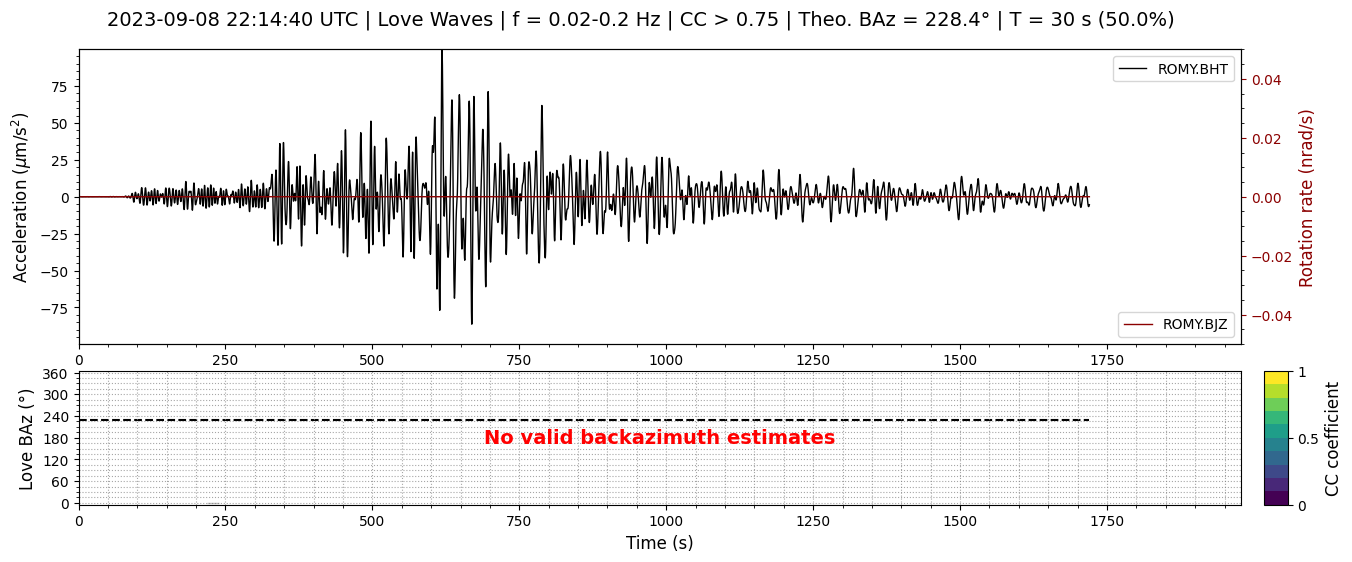

In [18]:
# First compute backazimuth
baz_results_love = sd.compute_backazimuth(
    wave_type='love',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results_love,
    wave_type='love',
    cc_method='mid',
    baz_theo=ev['backazimuth'],
    cc_threshold=config['cc_threshold'],
)

Computation of backazimuth results for Rayleigh waves using the midpoint CC-method

baz_max = 234, baz_std = 13


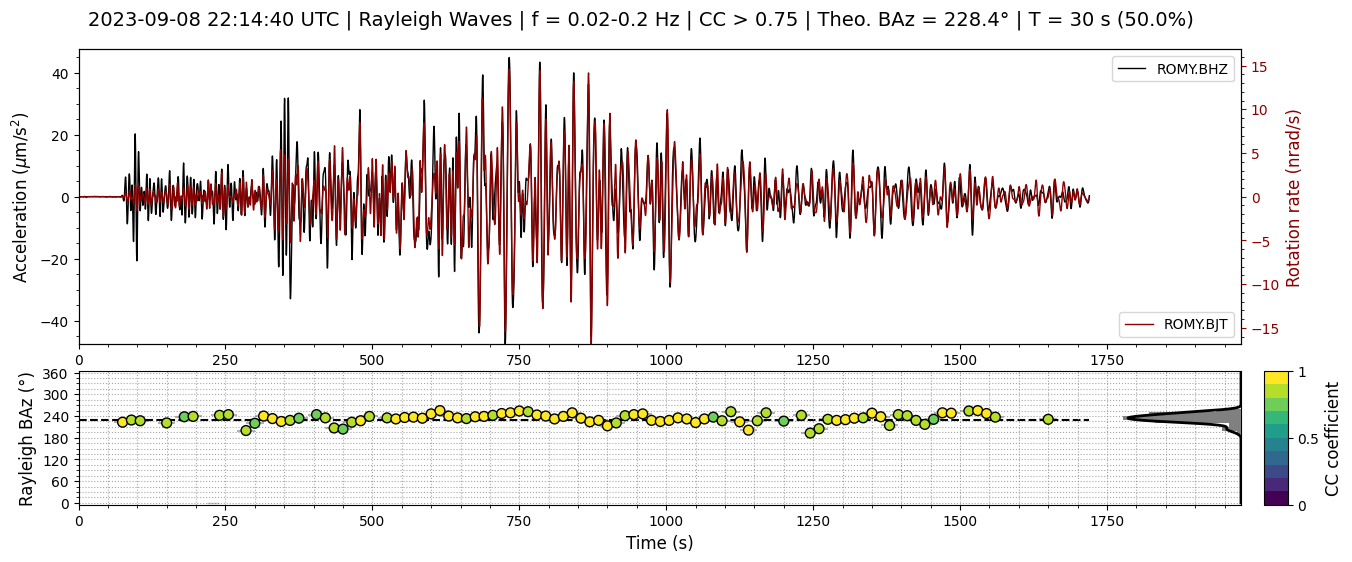

In [19]:
# First compute backazimuth
baz_results_rayleigh = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results_rayleigh,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_method='mid',
    cc_threshold=config['cc_threshold'],  # optional
)

Compare all three different methods for backazimuth estimation:

Using precomputed love backazimuth results

Estimated BAZ Love = nan° (CC ≥ 0.75)
Using precomputed rayleigh backazimuth results

Estimated BAZ Rayleigh = 234° (CC ≥ 0.75)
Computing tangent wave backazimuth...

Estimated BAZ Tangent = 235° (CC ≥ 0.75)


/home/andbro/anaconda3/envs/sixdegrees/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


KeyError: 'kde'

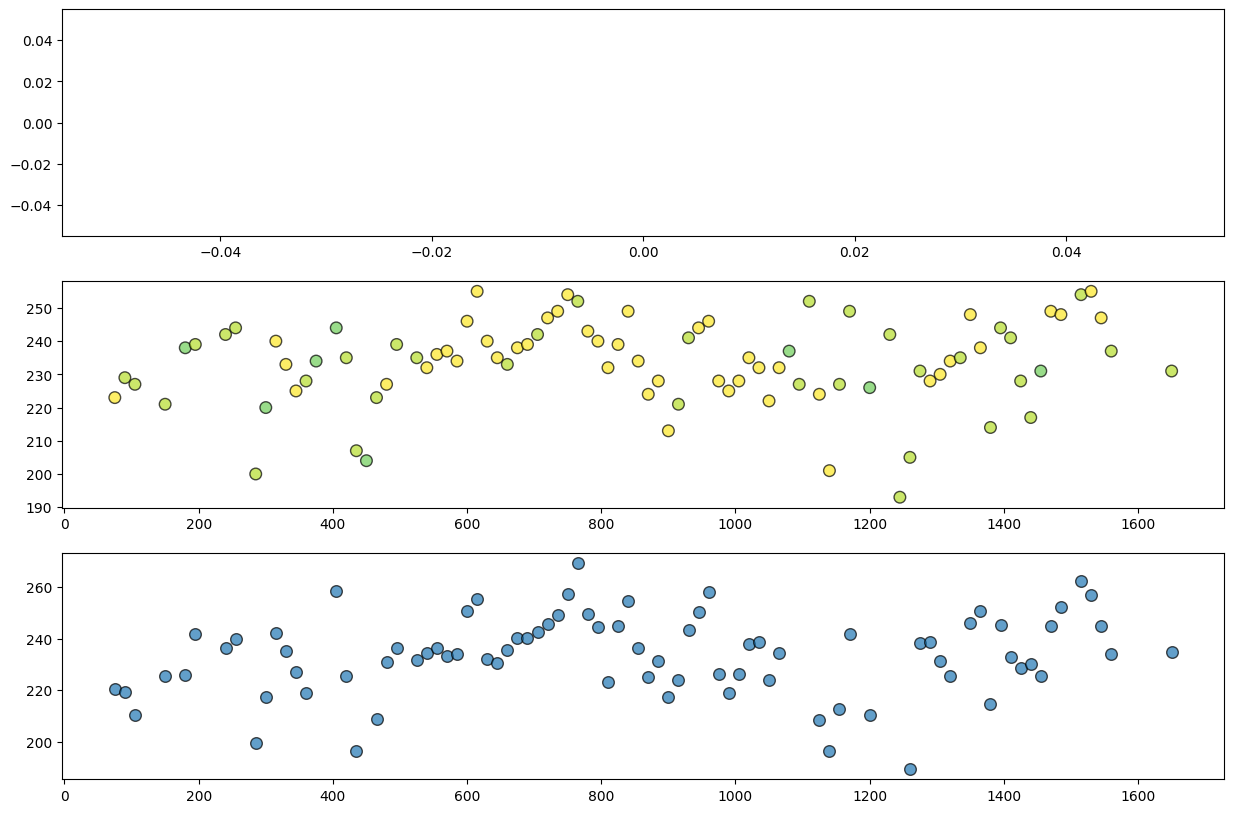

In [20]:
fig, _results = sd.compare_backazimuth_methods(
    Twin=config['twin_sec'],
    Toverlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    baz_theo=ev['backazimuth'],
    cc_method='mid',
    plot=True,
    output=True
)

### Analyse phase velocities

In [ ]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

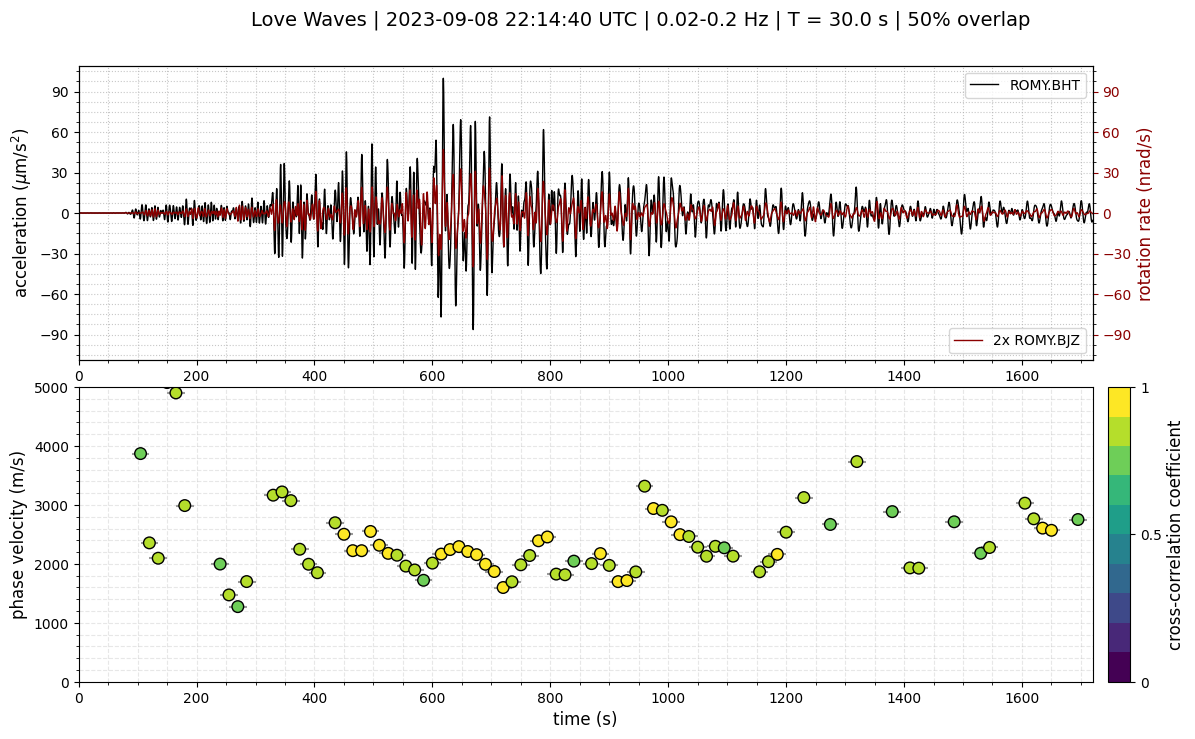

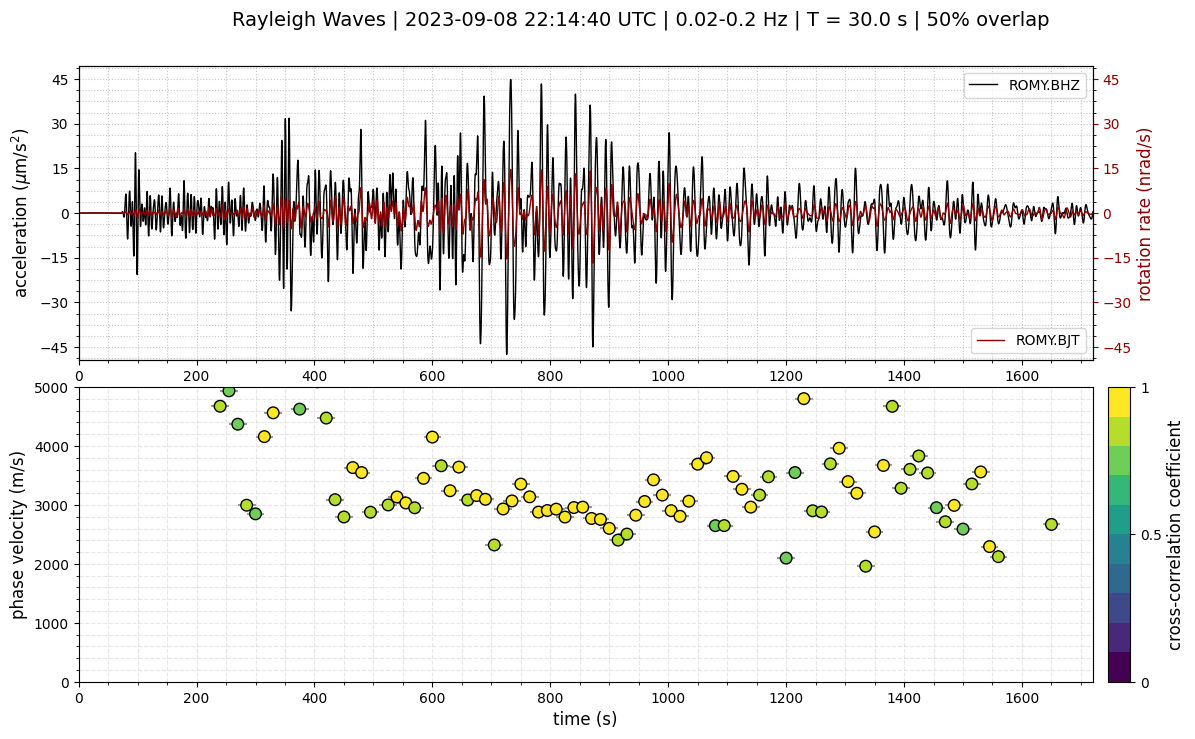

In [ ]:
# Plot results
fig = plot_velocities(sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)